In [25]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [26]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [27]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 200.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-x * par.atm2Pa for x in [3.0, 1.0]], # [atm --> Pa]
    logf = [4.0, 5.0],
    n = [1.0],
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

In [29]:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 50    # number os total searches

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=gd.rand_point(ranges, padding=0.1),
    step_limit=200,
    first_step=0.05, #between two parameter combinations
    min_step=1e-4, #between two parameter combinations
    decay=0.6,
    delta=1e-5,
    log10=False,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

In [30]:
"""Save settings as txt"""

# create folder for parameter study results:
file = gd.de.Make_dir('2_plus_1_gradient_search/1_atm_gd_smaller_intervals')

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [31]:
""" Gradient method, multithread"""

best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        all_datas, best_outputs, elapsed = result
        point_num = sum([len(datas) for datas in all_datas])
        total_point_num += point_num
        num += 1
        to_plot.append(best_outputs)
        if len(all_datas) > 0 and len(all_datas[-1]) > 0:
            last_points.append(gd.de.copy(all_datas[-1][0]))
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]

        # save points
        file.new_file()
        for datas in all_datas:
            for data in datas:
                file.write_line(data)
        file.close()
        del(all_datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps and {point_num: <4} points, finished in {elapsed: 8.2f} [s]   ({(elapsed / point_num): 4.2f} [s/run]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 5.045038010153513e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -229960.88407507265, 'logf': 4.8407328487204975, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
  1/50: Total 1   steps and 1    points, finished in    19.41 [s]   ( 19.41 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  1000000000000000019884624838656.0)
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00010174467220663521, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -141247.9236691135, 'logf': 4.563717649781388, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 7.158859232172539e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -179677.91773194438, 'logf': 4.792355152946847, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00010165015989592651, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -137369.63259898443, 'logf': 4.586833651901574, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00012820726348000526, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -146180.67615633248, 'logf': 4.445386327738441, 'n

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  3/50: Total 13  steps and 73   points, finished in   164.59 [s]   ( 2.25 [s/run]).   Final energy_efficiency:  87528018642028072445935616.0 (best:  87528018642028072445935616.0)
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00010164346508839022, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -137605.7862968487, 'logf': 4.586961473250264, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1194772847023D-03   r2 =  0.6333612403055D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1194772847023D-03   r2 =  0.63

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8600480124601D-01   r2 =  0.5979272585763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8600480124601D-01   r2 =  0.5979272585763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8600480124601D-01   r2 =  0.5979272585763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8600480124601D-01   r2 =  0.5979272585763D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7359590712228D-01   r2 =  0.6669362340116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7359590712228D-01   r2 =  0.6669362340116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7359590712228D-01   r2 =  0.6669362340116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7359590712228D-01   r2 =  0.6669362340116D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3355413769961D+00   r2 =                  NaN
  6/50: Total 18  steps and 92   points, finished in   140.70 [s]   ( 1.53 [s/run]).   Final energy_efficiency:  23082142989443652093214720.0 (best:  23082142989443652093214720.0)


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8794439524204D-01   r2 =  0.1065223163106D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8794439524204D-01   r2 =  0.1065223163106D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1426442758711D+00   r2 =  0.1200292521897D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8483511144123D+00   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5488684707730D+00   r2 =  0.2309160891545D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5488684707730D+00   r2 =  0.4618321783090D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5488684707730D+00   r2 =  0.4618321783090D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5488684707730D+00   r2 =  0.4618321783090D-16
 lsoda--  at t (=r1), too much accur

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4944931781340D+00   r2 =  0.1238475208963D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5577552420764D+00   r2 =  0.3882806607523D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2544811949351D+00   r2 =  0.7770056469279D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3890669950842D+00   r2 =  0.2906064798717D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Error, central point failed
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4441332388059D+00   r2 =  0.1490396008196D-06
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4041022300764D+00   r2 =  0.1277564336739D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1289707115826D+00   r2 =  0.3687176075942D-07
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsod

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8214313784402D+00   r2 =  0.1362370464781D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4508902593426D+00   r2 =  0.2270731332790D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2386232617551D+00   r2 =  0.1881814742875D-07
	Error, central point failed


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2386232617551D+00   r2 =  0.1881814742875D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00016063012132011664, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -168260.51935161088, 'logf': 4.762605874072704, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6195531020664D+00   r2 =  0.5344344366641D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; forward_delta=1e-05
	Error, central point failed
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2554010463197D+00   r2 =  0.1021979503081D-06
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00015927551492598326, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -168887.22209495932, 'logf': 4.758652485085237, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
  9/50: Total 27  steps and 135  points, finished in   561.33 [s]   ( 4.16 [s/run]).   Final energy_efficiency:    964.7 (best:  959.1)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=2; forward_delta=2e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1044667017880D-04   r2 =  0.7614504682638D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1044667017880D-04   r2 =  0.7614504682638D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1044667017880D-04   r2 =  0.7614504682638D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1044667017880D-04

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4512370519203D+00   r2 =                  NaN
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7091022950784D+00   r2 =  0.1805974110231D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 12/50: Total 36  steps and 181  points, finished in   925.57 [s]   ( 5.11 [s/run]).   Final energy_efficiency:   1014.7 (best:  959.1)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4103391736936D-01   r2 =  0.2904224978833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4103391736936D-01   r2 =  0.2904224978833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4103391736936D-01   r2 =  0.2904224978833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638966095876D-01   r2 =  0.3148499256678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638966095876D-01   r2 =  0.3148499256678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638966095876D-01   r2 =  0.3148499256678D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638966095876D-01   r2 =  0.3148499256678D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00018140185650163246, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -165397.09919142612, 'logf': 4.46519824420157, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287261313624D+00   r2 =  0.1367058566800D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287261313624D+00   r2 =  0.1367058566800D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1409437718903D+00   r2 =  0.1416805543662D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1509475177564D+00   r2 =  0.6188780360299D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9641915241005D+00   r2 =  0.2731969902000D-07
 14/50: Total 13  steps and 71   points, finished in   190.40 [s]   ( 2.68 [s/run]).   Final energy_efficiency:  2132983091792560248636571648.0 (best:  959.1)
	Warning, forward point failed, trial_num=1; forward_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6081150775167D+00   r2 =  0.5130258573683D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda-

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638208928211D+00   r2 =  0.2306890913931D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638208928211D+00   r2 =  0.2306890913931D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638208928211D+00   r2 =  0.2306890913931D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3638208928211D+00   r2 =  0.2306890913931D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 17/50: Total 14  steps and 76   points, finished in   145.21 [s]   ( 1.91 [s/run]).   Final energy_efficiency:  173650726327741215819169792.0 (best:  959.1)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184368940648D+00   r2 =  0.1287869760918D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184368940648D+00   r2 =  0.1287869760918D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184368940648D+00   r2 =  0.1287869760918D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184368940648D+00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4036834852079D+00   r2 =  0.1826357889123D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2881422248117D+00   r2 =  0.1191069864945D-06
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
	Error, central point failed
	Error, central point failed


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2463697462609D+00   r2 =  0.7762770064490D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827897026734D+00   r2 =  0.5118818876489D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827897026734D+00   r2 =  0.5118818876489D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827897026734D+00   r2 =  0.5118818876489D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2179481156771D+00   r2 =  0.1358278211372D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2179481156771D+00   r2 =  0.1358278211372D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2179481156771D+00   r2 =  0.1358278211372D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2179481156771D+00   r2 =  0.1358278211372D-16
 lsoda-

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1818142991856D+00   r2 =  0.1171725977034D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1818142991856D+00   r2 =  0.1171725977034D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1818142991856D+00   r2 =  0.1171725977034D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1818142991856D+00   r2 =  0.1171725977034D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 20/50: Total 25  steps and 145  points, finished in  1204.99 [s]   ( 8.31 [s/run]).   Final energy_efficiency:    869.3 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4211181429035D+00   r2 =  0.2059928891728D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3236438305699D+00   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2431302347815D+00   r2 =  0.1285045772189D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2431302347815D+00   r2 =  0.1285045772189D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2431302347815D+00   r2 =  0.1285045772189D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2431302347815D+00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4059616465544D+00   r2 =  0.4667348145078D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7236497703027D+00   r2 =  0.7109648152164D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 22/50: Total 28  steps and 142  points, finished in   668.43 [s]   ( 4.71 [s/run]).   Final energy_efficiency:    974.5 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3537080177297D+00   r2 =  0.1403530021978D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655130116721D+00   r2 =  0.1341081194845D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
	Error, central point failed
 23/50: Total 16  steps and 82   points, finished in    86.50 [s]   ( 1.05 [s/run]).   Final energy_efficiency:  6709980931375054263943168.0 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1736611596033D+00   r2 =  0.6416365612902D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9987198562256D+00   r2 =  0.9766721911362D-09
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 24/50: Total 36  steps and 182  points, finished in   772.46 [s]   ( 4.24 [s/run]).   Final energy_efficiency:   1382.3 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1310132684219D+00   r2 =  0.5014500248655D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2134481543074D+00   r2 =  0.3931319243671D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3847248327011D-04   r2 =  0.2723565183165D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.38472483

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 25/50: Total 16  steps and 84   points, finished in   164.41 [s]   ( 1.96 [s/run]).   Final energy_efficiency:  29871381985653321183002624.0 (best:  869.3)
 26/50: Total 28  steps and 143  points, finished in   714.95 [s]   ( 5.00 [s/run]).   Final energy_efficiency:   1054.4 (best:  869.3)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8557862043123D-02   r2 =  0.7691884559377D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8557862043123D-02   r2 =  0.7691884559377D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1461435741061D+00   r2 =  0.1290375436854D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1461435741061D+00   r2 =  0.1290375436854D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1461435741061D+00   r2 =  0.1290375436854D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1461435741061D+00   r2 =  0.1290375436854D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4336232530983D+00   r2 =  0.1980646255484D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5320668003107D-04   r2 =  0.3100121801981D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5320668003107D-04   r2 =  0.3100121801981D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5320668003107D-04   r2 =  0.3100121801981D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2723897210597D+00   r2 =  0.2327912224595D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2723897210597D+00   r2 =  0.2327912224595D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2723897210597D+00   r2 =  0.2327912224595D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2723897210597D+00   r2 =  0.2327912224595D-16
 lsoda-

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4081948601128D+00   r2 =  0.3669598362793D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 27/50: Total 31  steps and 165  points, finished in   983.18 [s]   ( 5.96 [s/run]).   Final energy_efficiency:    911.1 (best:  869.3)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, backward point failed, trial_num=1; backward_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2051756587443D+00   r2 =  0.1161640387248D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2051756587443D+00   r2 =  0.1161640387248D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2051756587443D+00   r2 =  0.1161640387248D-16
 lsoda-- 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Error, central point failed


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7986235083556D+00   r2 =  0.4906673360347D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7986235083604D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5384753506738D+00   r2 =  0.8816354586332D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2399948800038D+00   r2 =  0.1143839457905D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2975771275542D+00   r2 =  0.1035103157682D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1943376471758D+00   r2 =  0.2663778193405D-07
 30/50: Total 31  steps and 164  points, finished in   852.59 [s]   ( 5.20 [s/run]).   Final energy_efficiency:    975.6 (best:  869.3)
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3171347146064D+00   r2 =  0.4351426270298D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6305229754952D+00   r2 =  0.8176070450436D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3378227263783D+00   r2 =  0.2632218169472D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5572117090423D+00   r2 =  0.5493905397575D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5572117090423D+00   r2 =  0.4584673327189D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5572117090466D+00   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6635919425198D+00   r2 =                  NaN
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6425344961020D+00   r2 =  0.4566700982361D-16
 lsoda--  warning..internal t (=r

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3511967809030D+00   r2 =  0.1140113104080D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3779376396144D+00   r2 =  0.2123318410973D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3779376396187D+00   r2 =                  NaN
	Warning, forward point failed, trial_num=2; current_delta=2e-05
	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1472168227649D+00   r2 =  0.2397502544024D-07
	Warning, forward point failed, trial_num=1; current_delta=1

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.0001611188756249368, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -114606.24983834063, 'logf': 4.235486791684435, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2707281693880D-02   r2 =  0.1789638755282D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2707281693880D-02   r2 =  0.1789638755282D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5636289499157D+00   r2 =  0.8835293885971D-08
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7881471249931D+00   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5636289499157D+00   r2 =  0.8835293885971D-08
	Warning, forward point failed, trial_num=2; current_delta=2e-05
 34/50: Total 33  steps and 167  points, finished in   826.50 [s]   ( 4.95 [s/run]).   Final energy_efficiency:   2524.1 (best:  869.3)
 35/50: Total 13  steps and 69   points, finished in   165.72 [s]   ( 2.40 [s/run]).   Final energy_efficiency:  30474981627619041846755328.0 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5356268905645D+00   r2 =  0.3494832601332D-08
	Error, central point failed
	Error, 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2748399222002D+00   r2 =                  NaN
 37/50: Total 36  steps and 187  points, finished in   826.34 [s]   ( 4.42 [s/run]).   Final energy_efficiency:    999.0 (best:  869.3)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3012319787460D-04   r2 =  0.1565365884418D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3012319787460D-04   r2 =  0.1565365884418D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.30123197

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 38/50: Total 33  steps and 179  points, finished in  1122.99 [s]   ( 6.27 [s/run]).   Final energy_efficiency:    978.0 (best:  869.3)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2373211007988D-02   r2 =  0.2078596585222D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2373211007988D-02   r2 =  0.2078596585222D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2373211007988D-02   r2 =  0.2078596585222D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 9.258158917669157e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -142104.07862607267, 'logf': 4.736610103949614, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859502769232D-03   r2 =  0.5372326241816D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859502769232D-03   r2 =  0.5372326241816D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859502769232D-03   r2 =  0.5372326241816D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859502769232D-03   r2 =  0.4281683950466D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285336003308D-04   r2 =  0.2970454120407D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285336003308D-04   r2 =  0.2970454120407D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285336003308D-04   r2 =  0.2970454120407D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6845268582077D+00   r2 =  0.1038831539163D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6795573173696D-04   r2 =  0.5666770846696D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6795573173696D-04   r2 =  0.5666770846696D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6795573173696D-04   r2 =  0.4588220693388D-20
 lsoda--  warning..internal t (=r1)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6022372515124D+00   r2 =  0.1617900999808D-06
	Warning, forward point failed, trial_num=1; current_delta=1e-05


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3741921803004D+00   r2 =  0.2341282504957D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3741921803004D+00   r2 =  0.2341282504957D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3741921803004D+00   r2 =  0.2341282504957D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3741921803004D+00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8915437262094D+00   r2 =  0.8274557021374D-08
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3222933649148D-04   r2 =  0.3334733684150D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3222933649148D-04   r2 =  0.3334733684150D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3222933649148D-04   r2 =  0.3334733684150D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4237255673297D+00   r2 =  0.1501214706375D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, backward point failed, trial_num=1; backward_delta=1e-05
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 9.311078275006761e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -233525.57697478647, 'logf': 4.64240822476278, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9979815887683D+00   r2 =  0.5547730633613D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9979815887683D+00   r2 =  0.5547730633613D-16
 lsoda--  warning..internal t (=r

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9177440312359D-01   r2 =  0.3202213557936D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3140929830806D-03   r2 =  0.2320019356471D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3140929830806D-03   r2 =  0.2320019356471D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
     

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8541438779498D-01   r2 =  0.6510445960991D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8541438779498D-01   r2 =  0.6510445960991D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8541438779498D-01   r2 =  0.6510445960991D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8541438779498D-01   r2 =  0.6510445960991D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3600528404333D+00   r2 =  0.1127574594786D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3319949430347D-04   r2 =  0.2719537160790D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3319949430347D-04   r2 =  0.2719537160790D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3319949430347D-04   r2 =  0.2719537160790D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the mach

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 43/50: Total 30  steps and 166  points, finished in  1129.88 [s]   ( 6.81 [s/run]).   Final energy_efficiency:    870.2 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6258910475782D+00   r2 =  0.2265954362549D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2611550345168D+00   r2 =  0.1533435907642D-07
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 9.305285885832222e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -233414.3453683267, 'logf': 4.64181497589856, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7208739799084D+00   r2 =  0.3069929499248D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4453960145238D+00   r2 =  0.1827017979004D-06
	Error, gradient can not be calculated in point {'ID': 0, 'R_E': 0.00010221402977477403, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -171898.45148882884, 'logf': 4.800811076080273, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901}
 45/50: Total 15  steps and 83   points, finished in   111.09 [s]   ( 1.34 [s/run]).   Final energy_efficiency:  50200308410848768597950464.0 (best:  869.3)
 lsoda--  at t (=r1) and step size h (=r2), the      
       c

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 46/50: Total 29  steps and 152  points, finished in   717.49 [s]   ( 4.72 [s/run]).   Final energy_efficiency:    953.2 (best:  869.3)
	Error, central point failed
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5020640922210D+00   r2 =  0.2011783139255D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7336562123089D+00   r2 =  0.4348895288571D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7088959637957D-01  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1939569496762D+00   r2 =  0.6227996893215D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1106038957889D+00   r2 =  0.1212866743793D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6930243212231D+00   r2 =  0.3259855469943D-06
	Error, central point failed
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1106038957889D+00   r2 =  0.1212866743793D-07
	Warning, forward point failed, trial_num=1; current_delta=1e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7439604365505D+00   r2 =  0.7485316552796D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7439604365505D+00   r2 =  0.7485316552796D-07
 lsoda--  at t (=r1) and step size h (=r2), the      


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6405217536612D-01   r2 =                  NaN
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6112001958412D+00   r2 =  0.5368210999303D-07
	Error, central point failed
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2050866091423D+00   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1806432022736D+00   r2 =  0.1193576205748D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continu

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2821461272094D+00   r2 =  0.2445047859371D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2821461272094D+00   r2 =  0.2445047859371D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2821461272094D+00   r2 =  0.2445047859371D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2821461272094D+00   r2 =  0.2445047859371D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Warning, forward point failed, trial_num=2; current_delta=2e-05
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3052399088975D+00   r2 =  0.8757103936925D-07
 50/50: Total 34  steps and 190  points, finished in   967.92 [s]   ( 5.09 [s/run]).   Final energy_efficiency:    875.2 (best:  869.3)


DONE
total time:  0 hours  56 mins
             3387.70 [s]   ( 0.57 [s/run])


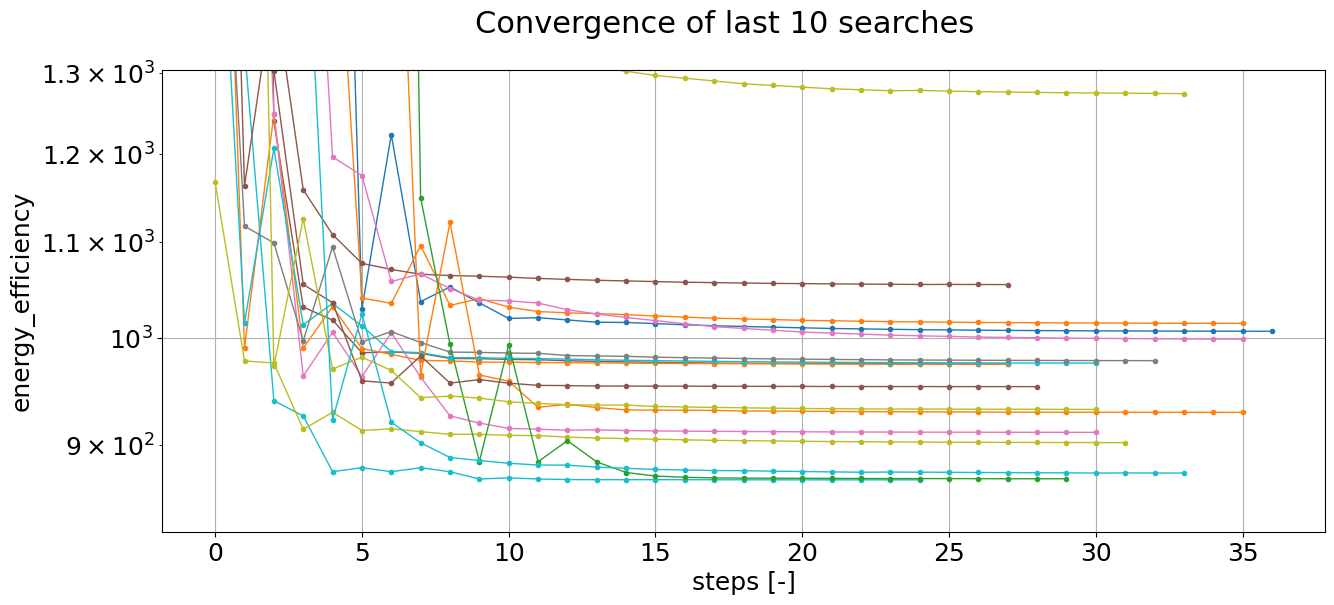

In [33]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.95*best_output, 1.5*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

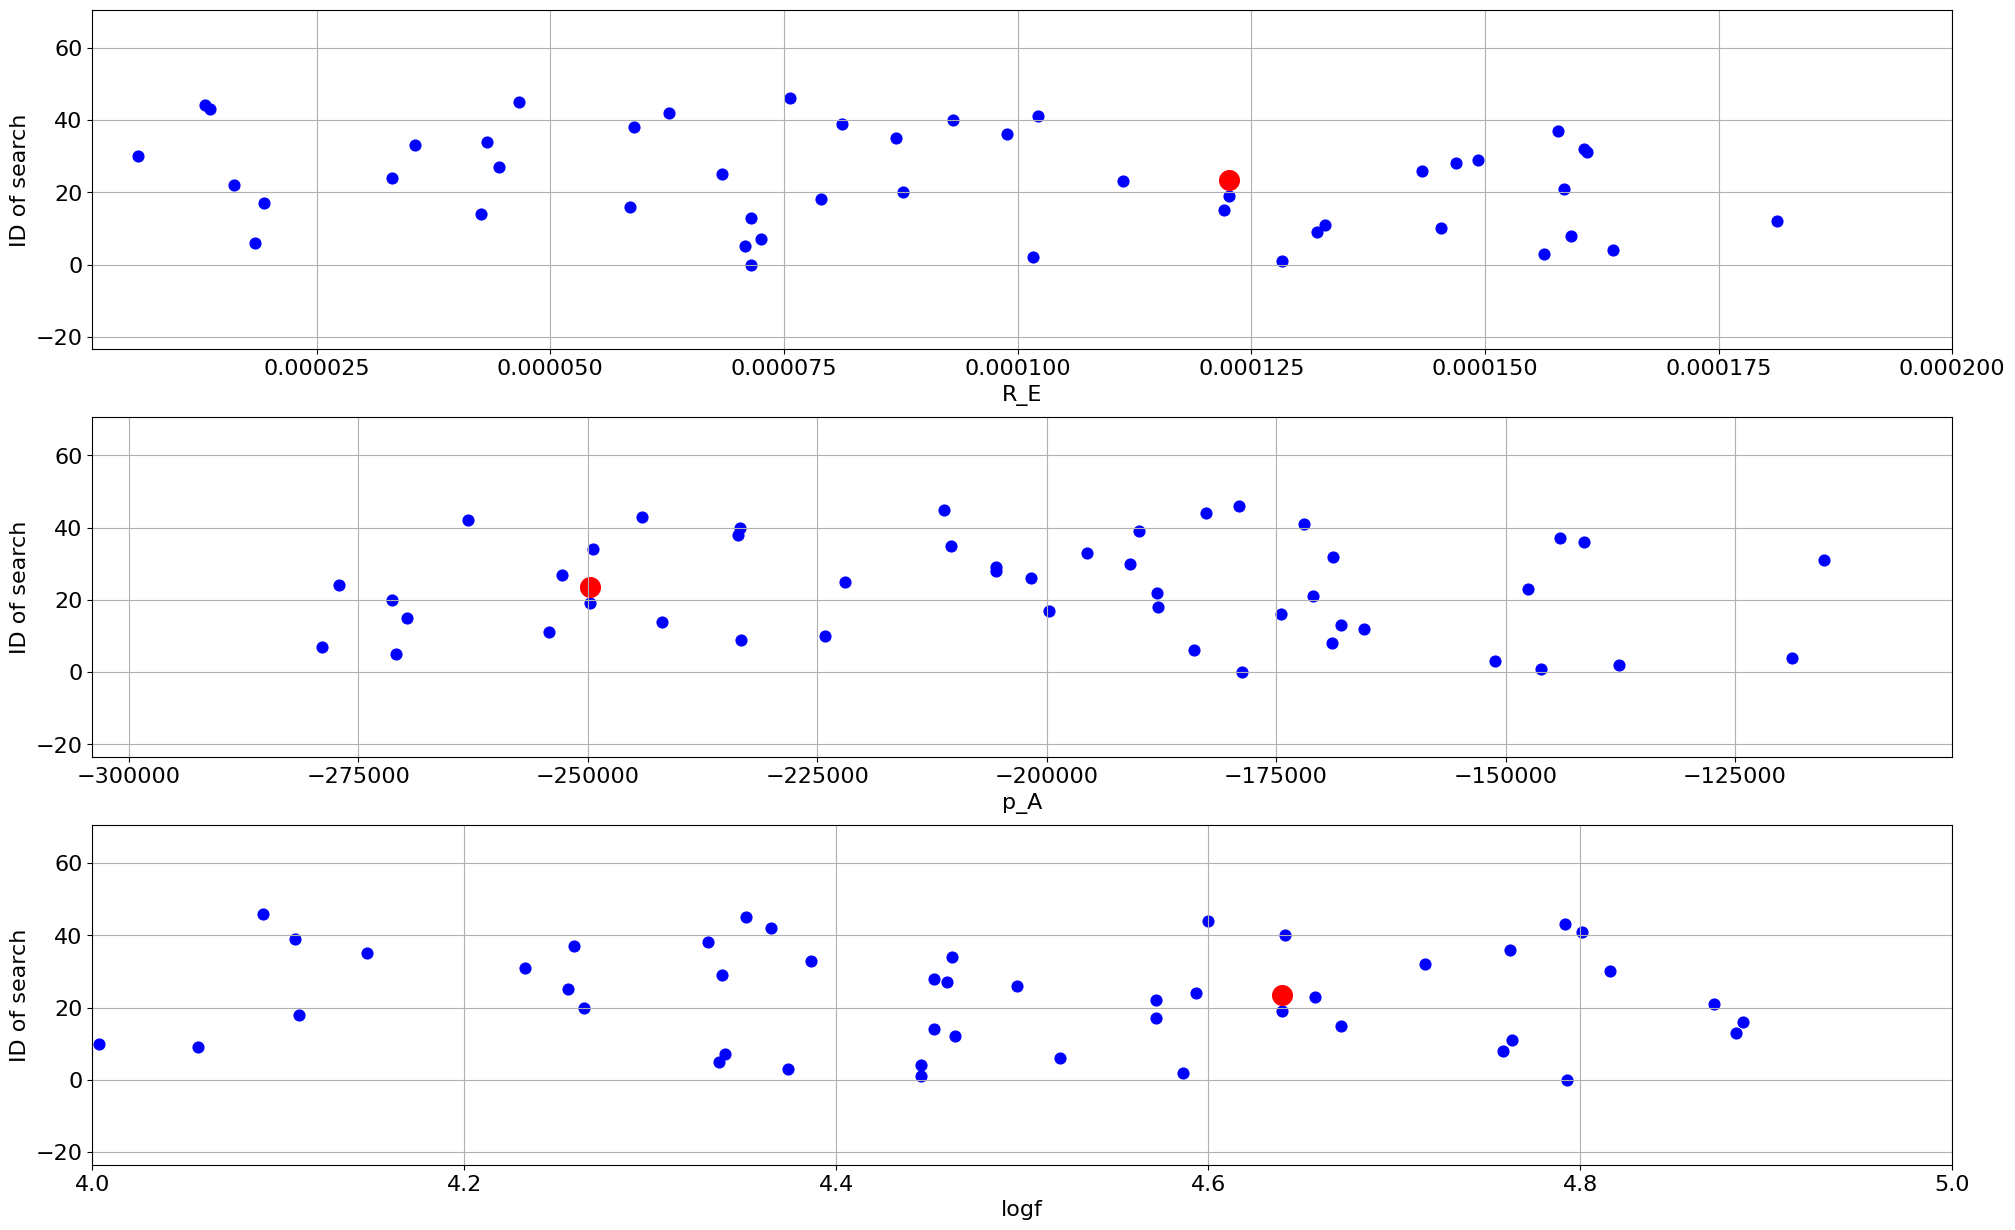

In [34]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
